# **Выводы из неудачных заказов**



---



---



---





**Этот проект по обработке данных использовался в качестве домашнего задания в процессе найма на должности специалистов по обработке данных в Gett.**

**Gett, ранее известная как GetTaxi, представляет собой систему ориентированную исключительно на управление корпоративным наземным транспортом (GTM). У них есть приложение, в котором клиенты могут заказывать такси, а водители могут принимать их предложения о поездках. В тот момент, когда клиент нажимает кнопку Заказать в приложении, система сопоставления выполняет поиск наиболее подходящих драйверов и предлагает им заказать. В этой задаче мы хотели бы исследовать некоторые показатели соответствия для заказов, которые не были выполнены успешно, то есть клиент в конечном итоге не получил автомобиль.**

# **Задание**

---



---



---





*   **Создайте распределение заказов в соответствии с причинами сбоя: отмены до и после назначения водителя и причины отклонения заказа. Проанализируйте полученный график. В какой категории наибольшее количество заказов?**

*   **Постройте график распределения невыполненных заказов по часам. Существует ли тенденция к тому, что в определенные часы доля той или иной категории аномально высока? В какие часы происходят самые большие сбои? Как это можно объяснить?**
*   **Рассчитайте среднее время до отмены заказа с водителем и без него с разбивкой по часам. Если в данных есть какие-либо отклонения, было бы лучше их удалить. Можем ли мы сделать какие-либо выводы из этого графика?**


# **Импорт библиотек и знакомство с данными**

---



---



---



In [41]:
import pandas as pd
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import numpy as np
import folium
import json
from scipy import stats
import geopy.distance
from geopy.distance import geodesic
orders = pd.read_csv('/content/drive/MyDrive/DataSets/data_orders.csv')
offers = pd.read_csv('/content/drive/MyDrive/DataSets/data_offers.csv')
df = orders.merge(right=offers, how="inner", on="order_gk")


#  **Предобработка данных**

---



---



---



### **Переименование столбцов и значений**

In [42]:
df.rename(columns = {'order_datetime':'Время_выполнения_заказа', 'origin_longitude':'Долгота_заказа', 'origin_latitude':'Широта_заказа', 'm_order_eta':'Время_до_поступления_заказа','order_gk':'Номер_заказа', 
                         'order_status_key':'Статус_заказа', 'is_driver_assigned_key':'Был_ли_назначен_водитель', 'cancellations_time_in_seconds':'Секунд_до_отмены', 'offer_id':'Идентификатор_предложения'}, inplace = True )

In [43]:
df

,Время_выполнения_заказа,Долгота_заказа,Широта_заказа,Время_до_поступления_заказа,Номер_заказа,Статус_заказа,Был_ли_назначен_водитель,Секунд_до_отмены,Идентификатор_предложения
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,300050983403
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986179
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986174
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986180
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,300050976275
...,...,...,...,...,...,...,...,...,...
31263,12:44:11,-0.975372,51.457846,NaN,3000597886155,4,0,43.0,300051590196
31264,12:42:52,-0.975372,51.457846,NaN,3000597886140,4,0,44.0,300051590176
31265,13:11:35,-0.975372,51.457846,NaN,3000599186906,4,0,36.0,300051648809
31266,13:17:21,-0.972926,51.457693,60.0,3000599187034,4,1,34.0,300051648910


In [44]:
df["Был_ли_назначен_водитель"] = np.where(df["Был_ли_назначен_водитель"] == 1, "Да", "Нет")
df["Статус_заказа"] = np.where(df["Статус_заказа"] == 4, "Отклонено клиентом", "Отклонено системой")

# **Распределение заказов в соответствии с причинами сбоя: отмены до и после назначения водителя и причины отклонения заказа**

---



---



---



---



Статус_заказа                    index Отклонено клиентом         \
Был_ли_назначен_водитель                               Да    Нет   
0                         Номер_заказа               8360  13435   

Статус_заказа            Отклонено системой        
Был_ли_назначен_водитель                 Да   Нет  
0                                         4  9469

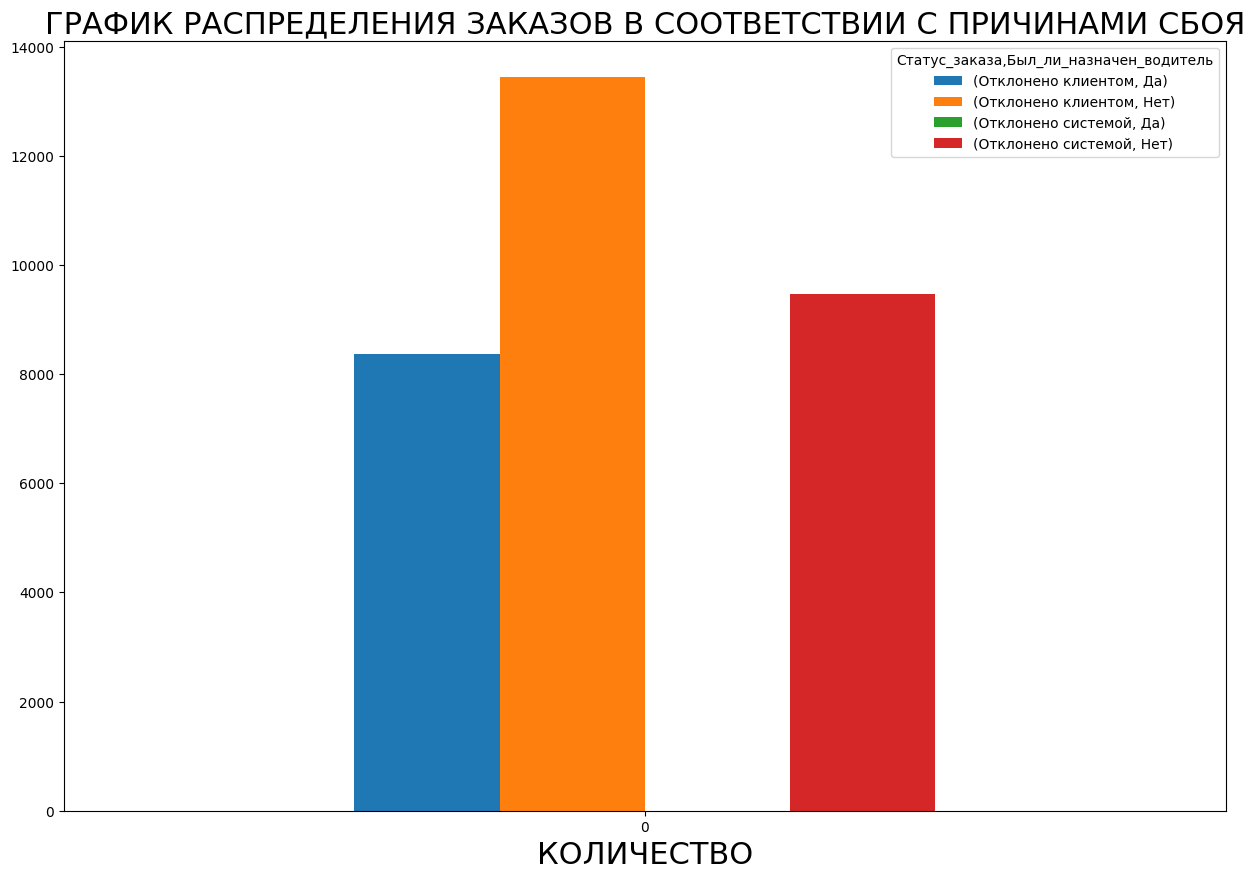

In [45]:
reasons_for_refusal = df.pivot_table(columns = ['Статус_заказа','Был_ли_назначен_водитель'], values = 'Номер_заказа', aggfunc = 'count').reset_index()
display(reasons_for_refusal)
reasons_for_refusal.plot(kind ='bar',figsize=(15, 10), legend=True,rot = 0)
plt.title('ГРАФИК РАСПРЕДЕЛЕНИЯ ЗАКАЗОВ В СООТВЕТСТВИИ С ПРИЧИНАМИ СБОЯ',fontsize = 22)
plt.xlabel('КОЛИЧЕСТВО',fontsize = 22)
plt.show()

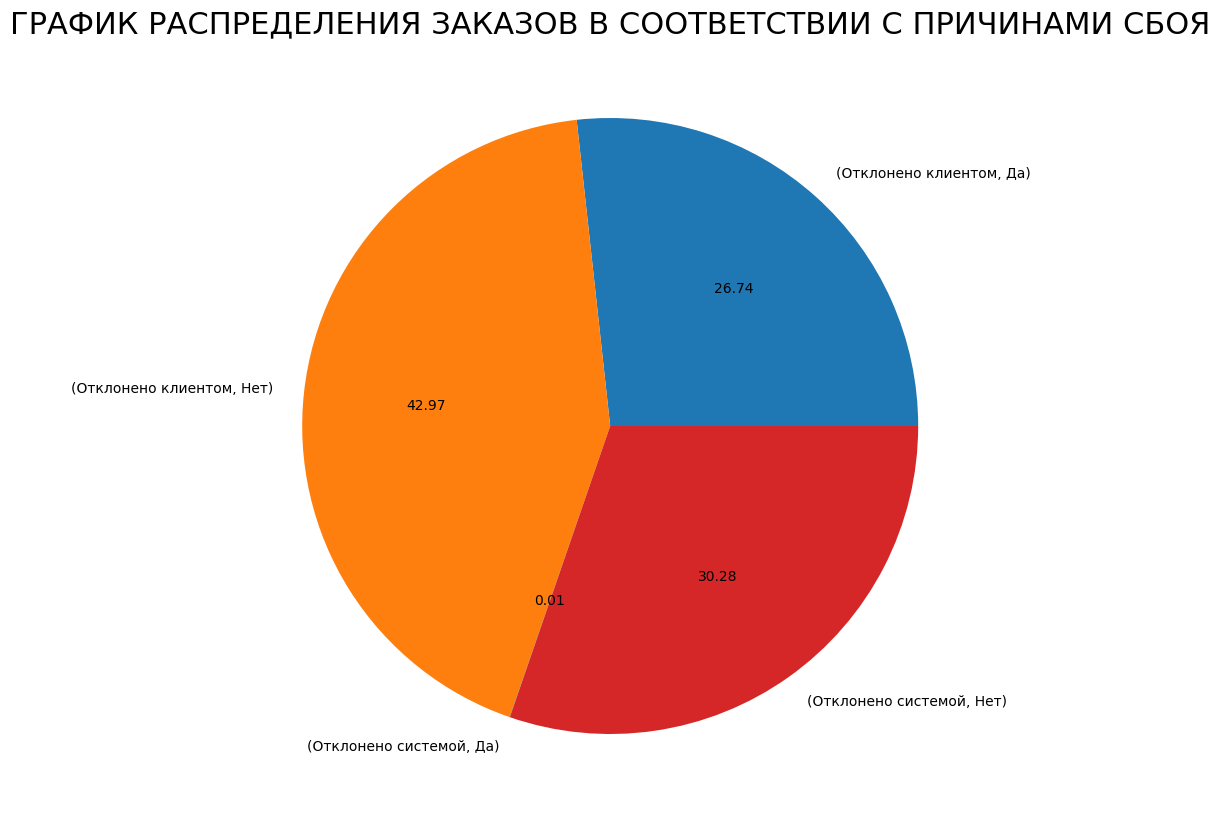

In [46]:
data_chain = df.groupby(['Статус_заказа','Был_ли_назначен_водитель'])['Номер_заказа'].count()
ax = data_chain.plot(kind = 'pie', x = 'chain', y='id', figsize=(20, 10), autopct="%.2f")
plt.title('ГРАФИК РАСПРЕДЕЛЕНИЯ ЗАКАЗОВ В СООТВЕТСТВИИ С ПРИЧИНАМИ СБОЯ',fontsize = 22)
ax.set_ylabel('')
plt.show()

**Мы видим, что отклонение заказов системой при назначенном водители практически отсутствуют. Чаще всего заказ отменяют клиенты до того, как водитель был назначен. Можно предположить гипотезу, что это происходит по причине долгого ожидания назначения водителя. На втором месте стоит отклонение системой при отсутствующем водителе, что нас тоже наводит на мысль, что это происходит по причине долгого ожидания назначения водителя.**

# **График распределения неудачных заказов по часам. Существует ли тенденция к тому, что в определенные часы доля той или иной категории ненормально высока? В какие часы происходят самые большие сбои? Как это можно объяснить?**

---



---



---



---



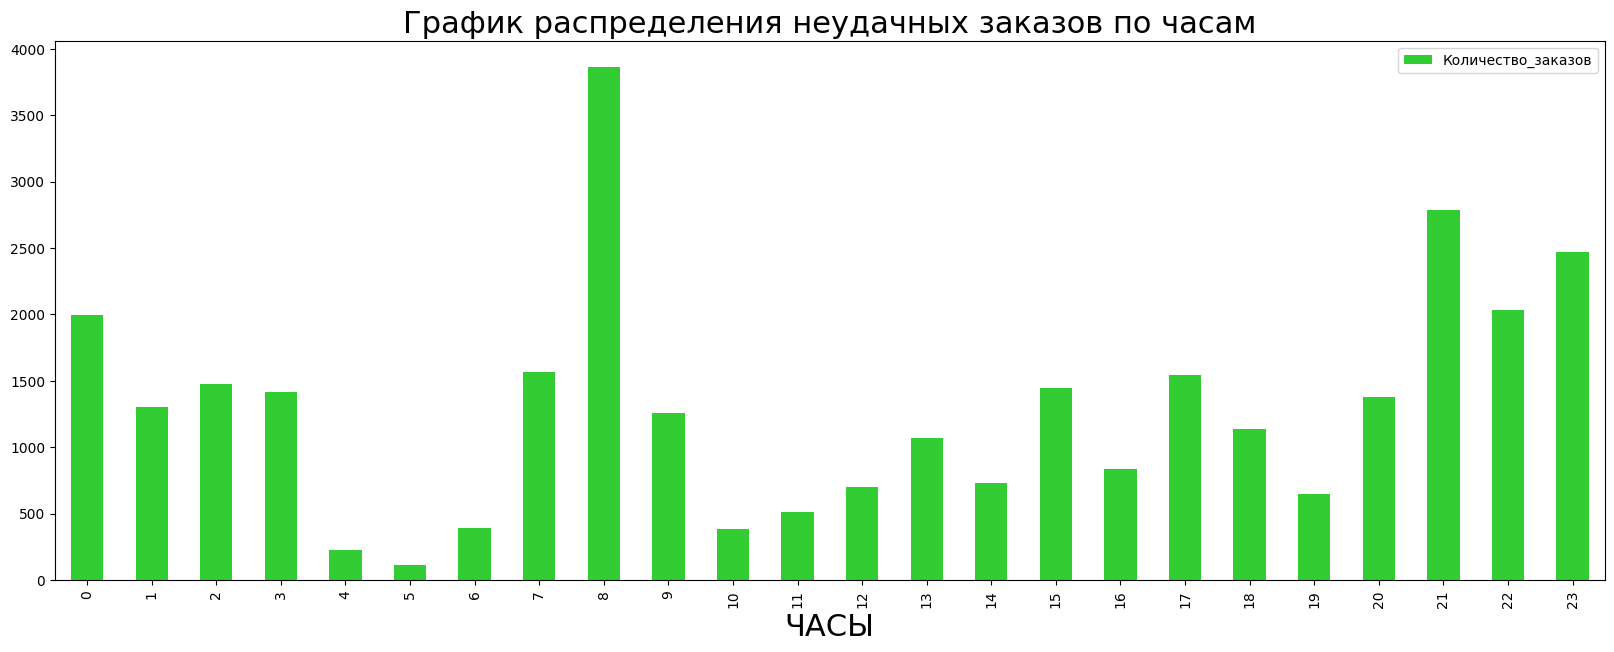

In [47]:
df["Час_выполнения_заказа"] = df["Время_выполнения_заказа"].str.split(":").apply(lambda split: split[0])
df.pivot_table(index = 'Час_выполнения_заказа', values = 'Номер_заказа', aggfunc = 'count').rename(columns={'Номер_заказа': 'Количество_заказов'}).plot(kind = 'bar', figsize=(20, 7),
                                                         legend=True,
                                                         xticks=range(0, 24), color = '#32CD32')
plt.title('График распределения неудачных заказов по часам',fontsize = 22)
plt.xlabel('ЧАСЫ',fontsize = 22)
plt.show()

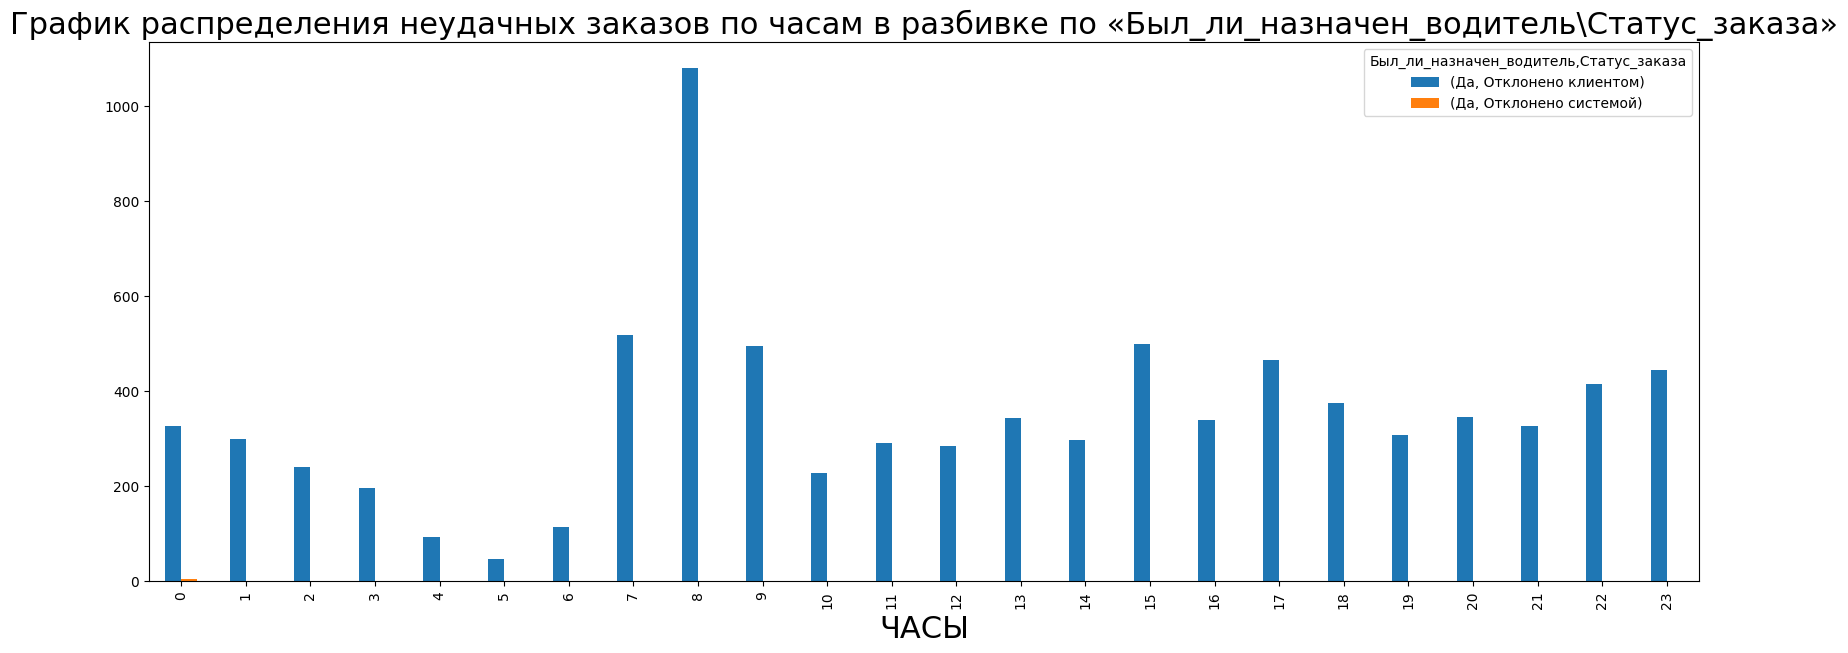

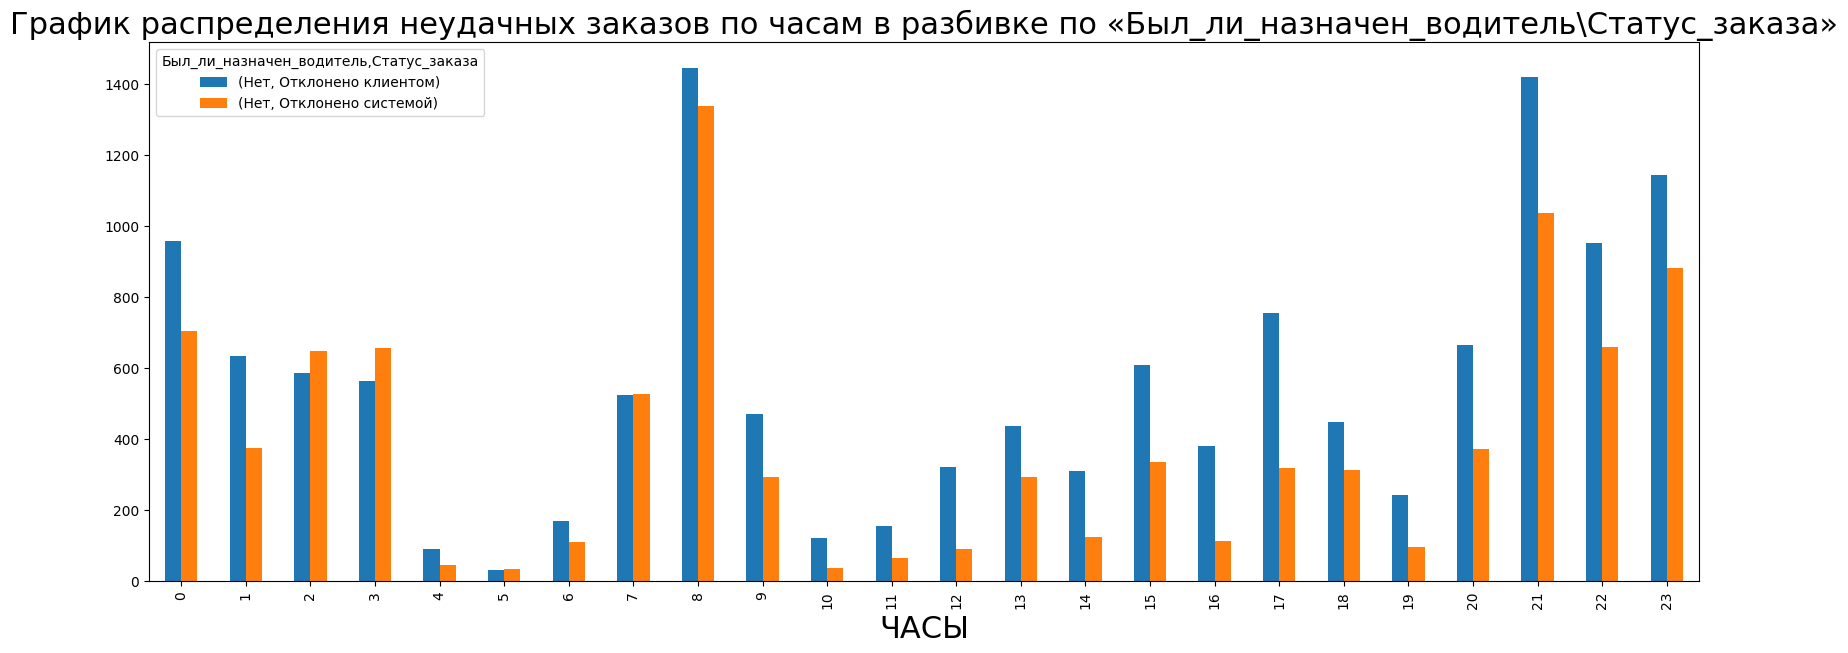

In [48]:
df[df['Был_ли_назначен_водитель'] == 'Да'].groupby(by=["Час_выполнения_заказа", "Был_ли_назначен_водитель", "Статус_заказа"])["Номер_заказа"].count().reset_index().pivot(index="Час_выполнения_заказа",
                                   columns=["Был_ли_назначен_водитель", "Статус_заказа"],
                                   values="Номер_заказа").plot(kind = 'bar',xticks=range(0, 24),
                                                           figsize=(20, 7))
plt.title('График распределения неудачных заказов по часам в разбивке по «Был_ли_назначен_водитель\Статус_заказа»',fontsize = 22)
plt.xlabel('ЧАСЫ',fontsize = 22)
plt.show() 

df[df['Был_ли_назначен_водитель'] != 'Да'].groupby(by=["Час_выполнения_заказа", "Был_ли_назначен_водитель", "Статус_заказа"])["Номер_заказа"].count().reset_index().pivot(index="Час_выполнения_заказа",
                                   columns=["Был_ли_назначен_водитель", "Статус_заказа"],
                                   values="Номер_заказа").plot(kind = 'bar',xticks=range(0, 24),
                                                           figsize=(20, 7))
plt.title('График распределения неудачных заказов по часам в разбивке по «Был_ли_назначен_водитель\Статус_заказа»',fontsize = 22)
plt.xlabel('ЧАСЫ',fontsize = 22)
plt.show()                                           

**Мы видим, что пик отказов приходится на 8 часов утра, как с назначенным водителем, так и без водителя. Есть предположение, что большинство отказов происходит в 8 часов утра по причине того, что это час-пик, что провоцирует большое количество заказов и нехватку водителей(нет данных для проверки).**

# **График среднего времени до отмены заказа с водителем и без него с разбивкой по часам**

---



---



---



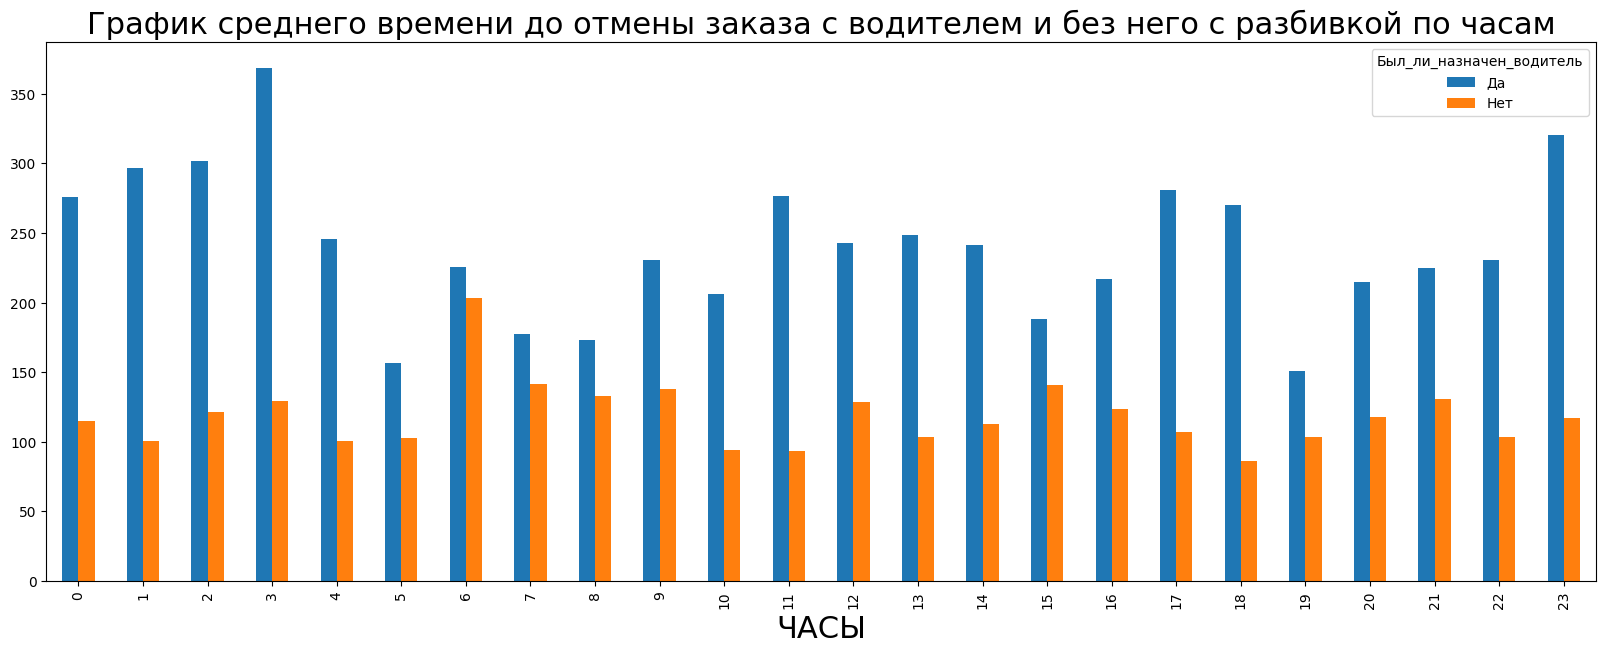

In [49]:
df.groupby(by=["Час_выполнения_заказа", "Был_ли_назначен_водитель"])["Секунд_до_отмены"].mean().reset_index().pivot(index="Час_выполнения_заказа",
                                   columns="Был_ли_назначен_водитель",
                                   values="Секунд_до_отмены").plot(kind = 'bar',xticks=range(0, 24),
                                                                                figsize=(20, 7))
plt.title('График среднего времени до отмены заказа с водителем и без него с разбивкой по часам',fontsize = 22)
plt.xlabel('ЧАСЫ',fontsize = 22)
plt.show()                                      

# **Выводы**

---



---



---



**Мы видим на графике "среднее время до отказа", что в те же 8 часов утра среднее время не отличается от другого часа, что лишний раз подталкивает нас к  гипотезе, что отказ приходится по причине нехватки автомобилей, а не из - за большого времени ожидания.Для дачи точных рекомендаций хотелось бы посмотреть данные не только с неудачными заказами, но в целом со всеми заказами. И так же не хватает данных о количестве водителей.**